In [1]:
import os
import sys
from importlib import reload
module_paths = [
    os.path.abspath(os.path.join('..')),
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
        
import torch
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import aav
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('darkgrid')

2024-03-04 23:16:56.554824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 23:16:56.554859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 23:16:56.555881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 23:16:56.562340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 23:16:58.375242: W tensorflow/comp

n_wt_pre = 92736.0
n_wt_post = 338347.0
Maximum variance: 2.0000


/tmp/ipykernel_83761/1103278674.py:18: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(origfit_n[: n_rows_with_counts]), logfit_n, s=1, alpha=0.2);


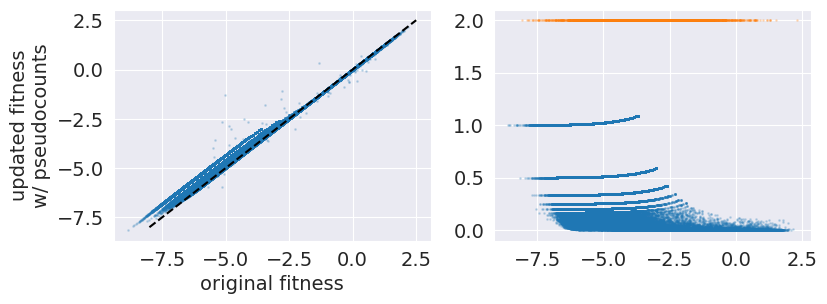

In [2]:
df = pd.read_csv('../data/elife-16965-supp1-v4.csv')
origfit_n = df['Fitness'].to_numpy()

wt_str = 'VDGV'
n_wt_post = df[df['Variants'] == wt_str]['Count selected'].item() + 1
n_wt_pre = df[df['Variants'] == wt_str]['Count input'].item() + 1
print('n_wt_pre = {}\nn_wt_post = {}'.format(n_wt_pre, n_wt_post))

# rows 0 through 149360 inclusive have counts
n_rows_with_counts = 149361
n_post = df['Count selected'].to_numpy()[: n_rows_with_counts] + 1
n_pre = df['Count input'].to_numpy()[: n_rows_with_counts] + 1
logfit_n = np.log(n_post / n_pre) - np.log(n_wt_post / n_wt_pre)
var_n = (1 / n_post) * (1 - (n_post / n_wt_post)) + (1 / n_pre) * (1 - (n_pre / n_wt_pre))

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(np.log(origfit_n[: n_rows_with_counts]), logfit_n, s=1, alpha=0.2);
plt.plot([-8, 2.5], [-8, 2.5], '--k');
plt.xlabel('original fitness');
plt.ylabel('updated fitness\nw/ pseudocounts')

plt.subplot(122)
plt.scatter(logfit_n, var_n, s=1, alpha=0.2);

# impute maximum variance for imputed fitness values
var_max = (1 / 1) * (1 - (1 / n_wt_post)) + (1 / 1) * (1 - (1 / n_wt_pre))
print('Maximum variance: {:.4f}'.format(var_max))
var_n = np.hstack([var_n, var_max * np.ones([160000 - n_rows_with_counts])])
logfit_n = np.hstack([logfit_n, np.log(origfit_n[n_rows_with_counts :])])
plt.scatter(logfit_n[n_rows_with_counts :], var_n[n_rows_with_counts :], s=1, alpha=0.2);


In [3]:
df['estimated_variance'] = var_n
df['log_fitness'] = logfit_n
df.to_csv('../data/gb1-with-variance.csv')

160000 160000 (160000, 4, 21)


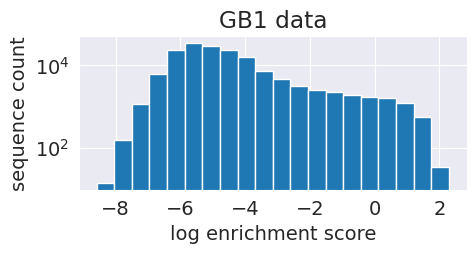

In [2]:
# df = pd.read_csv('../data/elife-16965-supp1-v4.csv')
df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()
var_n = df['estimated_variance'].to_numpy()
seq2yvar = {seq: [y, var] for seq, y, var in zip(seq_n, y_n, var_n)}
ohe_nxla = np.stack([utils.str2onehot(seq, aav.AA).flatten() for seq in seq_n])
ohe_nxlxa = np.stack([utils.str2onehot(seq, aav.AA) for seq in seq_n])
print(len(seq_n), y_n.size, ohe_nxlxa.shape)

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('log enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

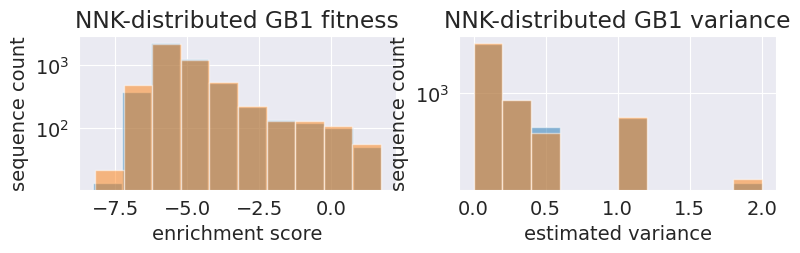

In [3]:
# generate NNK training and test data
reload(aav)
n_train = 5000
_, nnkohe_nxla, nnkseq_n = aav.sample_ohe_from_nuc_distribution(aav.PNUC_NNK_LXA, 2 * n_train)
ynnk_nx2 = np.array([seq2yvar[seq] for seq in nnkseq_n])

trainohe_nxla, testohe_nxla = nnkohe_nxla[: n_train], nnkohe_nxla[n_train :]
ytrain_nx2, ytest_nx2 = ynnk_nx2[: n_train], ynnk_nx2[n_train :]

plt.figure(figsize=(9, 2))
plt.subplot(121)
plt.hist(ytrain_nx2[:, 0], alpha=0.5, log=True);
plt.hist(ytest_nx2[:, 0], alpha=0.5, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('NNK-distributed GB1 fitness');

plt.subplot(122)
plt.hist(ytrain_nx2[:, 1], alpha=0.5, log=True);
plt.hist(ytest_nx2[:, 1], alpha=0.5, log=True);
plt.xlabel('estimated variance');
plt.ylabel('sequence count');
plt.title('NNK-distributed GB1 variance');


In [14]:
# train NN model
reload(gb1)
n_epoch = 30
n_hidden = 5
n_model = 3
lr = 1e-3
batch_size = 10
n_data_workers = 1
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
loss_tx2 = model.fit(
    trainohe_nxla,
    ytrain_nx2,
    lr=lr,
    batch_size=batch_size,
    n_epoch=n_epoch,
    n_data_workers=n_data_workers
)

Sequences are already one-hot encoded.
4500 training data points, 500 validation data points.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 321.62it/s]


Epoch 0. Train loss: 248.50. Val loss: 298.05. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 318.67it/s]


Epoch 1. Train loss: 170.24. Val loss: 179.27. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 321.83it/s]


Epoch 2. Train loss: 126.47. Val loss: 134.93. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 323.56it/s]


Epoch 3. Train loss: 97.04. Val loss: 96.67. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 319.46it/s]


Epoch 4. Train loss: 84.25. Val loss: 73.29. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 330.36it/s]


Epoch 5. Train loss: 78.77. Val loss: 65.13. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 332.09it/s]


Epoch 6. Train loss: 75.16. Val loss: 62.95. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 330.17it/s]


Epoch 7. Train loss: 71.98. Val loss: 60.84. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 326.37it/s]


Epoch 8. Train loss: 70.21. Val loss: 57.27. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 324.26it/s]


Epoch 9. Train loss: 65.84. Val loss: 55.69. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 323.36it/s]


Epoch 10. Train loss: 63.61. Val loss: 52.57. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 324.36it/s]


Epoch 11. Train loss: 61.01. Val loss: 53.72. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 326.21it/s]


Epoch 12. Train loss: 58.15. Val loss: 53.20. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 324.80it/s]


Epoch 13. Train loss: 55.96. Val loss: 49.53. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 318.21it/s]


Epoch 14. Train loss: 54.50. Val loss: 51.72. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 316.52it/s]


Epoch 15. Train loss: 52.06. Val loss: 49.14. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 320.97it/s]


Epoch 16. Train loss: 50.08. Val loss: 53.96. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 329.24it/s]


Epoch 17. Train loss: 47.78. Val loss: 49.08. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 315.62it/s]


Epoch 18. Train loss: 45.48. Val loss: 45.79. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 322.84it/s]


Epoch 19. Train loss: 43.62. Val loss: 45.20. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 319.10it/s]


Epoch 20. Train loss: 41.72. Val loss: 45.98. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 307.80it/s]


Epoch 21. Train loss: 39.97. Val loss: 43.55. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 325.95it/s]


Epoch 22. Train loss: 38.90. Val loss: 42.67. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 325.51it/s]


Epoch 23. Train loss: 36.66. Val loss: 42.39. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 328.29it/s]


Epoch 24. Train loss: 34.81. Val loss: 39.64. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 323.15it/s]


Epoch 25. Train loss: 33.48. Val loss: 37.39. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 320.11it/s]


Epoch 26. Train loss: 31.38. Val loss: 39.11. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 326.13it/s]


Epoch 27. Train loss: 30.04. Val loss: 36.63. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 319.24it/s]


Epoch 28. Train loss: 27.93. Val loss: 37.65. 1 sec.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 320.91it/s]

Epoch 29. Train loss: 26.42. Val loss: 34.59. 1 sec.


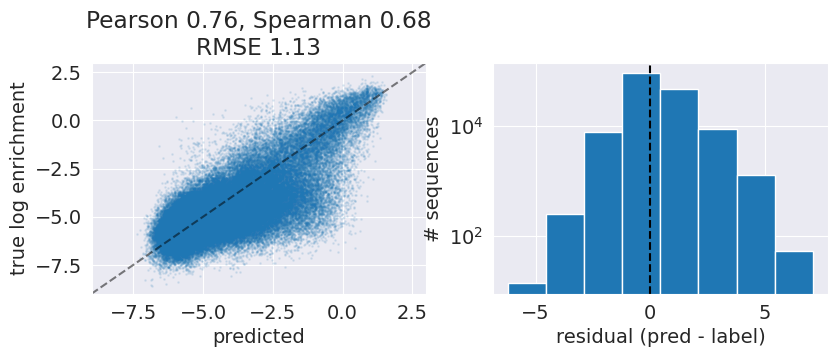

In [16]:
# test on all other sequences
testseq_n = [s for s in seq_n if s not in nnkseq_n[: n_train]]
ytest_n = np.array([seq2yvar[s][0] for s in testseq_n])
pred_n = model.predict(testseq_n)
xy_lim = [-9, 3]

plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(pred_n, ytest_n, alpha=0.1, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, pred_n)
rho, p = sc.stats.spearmanr(ytest_n, pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - pred_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

plt.subplot(122)
plt.hist(pred_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (pred - label)');

(5000, 4, 21)


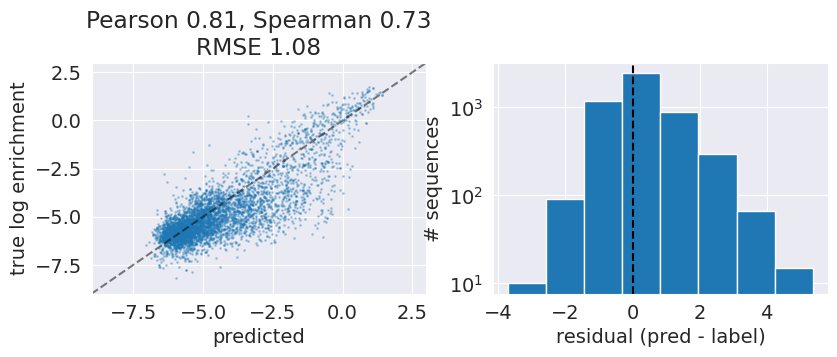

In [17]:
print(testohe_nxla.shape)
pred_n = model.predict(testohe_nxla)
xy_lim = [-9, 3]

plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(pred_n, ytest_nx2[:, 0], alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_nx2[:, 0], pred_n)
rho, p = sc.stats.spearmanr(ytest_nx2[:, 0], pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_nx2[:, 0] - pred_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

plt.subplot(122)
plt.hist(pred_n - ytest_nx2[:, 0], bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (pred - label)');

In [21]:
fname = 'gb1-h{}-{}k-030423'.format(n_hidden, int(n_train / 1000))
model.save(fname)
train_idx = np.array([seq_n.index(seq) for seq in nnkseq_n])
np.savez('../aav-models/{}-train-idx.npz'.format(fname), train_idx=train_idx)

Saved models to /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h5-5k-030423.pt.


In [25]:
# load model
reload(aav)
n_hidden = 10
n_model = 3
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('gb1-h10-5k-030123')

In [29]:
# get design distributions
# REMINDER: set save_fname_no_ftype appropriately!
reload(aav)
temperatures = np.arange(0.601, 0.701, 0.001)
lr = 0.1
n_sample = 1000
n_iter = 4000
pareto_tx3 = np.empty([temperatures.size, 3])

for t, temp in enumerate(temperatures):
    print('Temperature = {:.4f}'.format(temp))
    save_fname_no_ftype = 'gb1-h{}-{}k-t{:.4f}-030123'.format(n_hidden, int(n_train / 1000), temp)
    # save_fname_no_ftype = None
    
    t0 = time()
    theta_lxa, df = aav.solve_max_entropy_library(
        model,
        temperature=temp,
        lr=lr,
        n_sample=n_sample,
        n_iter=n_iter,
        save_fname_no_ftype=save_fname_no_ftype
    )
    
    paa_lxa = aav.get_aa_probs_from_nuc_probs(aav.normalize_theta(theta_lxa))
    pdesign_n = np.exp(aav.get_nostop_loglikelihood(aav.ALL_NOSTOP_AA_OHE, paa_lxa))
    truemean = np.sum([p * seq2yvar[seq][0] for p, seq in zip(pdesign_n, aav.ALL_NOSTOP_AA_SEQS)])
    pareto_tx3[t] = df.loc[n_iter]['mean_prediction'], df.loc[n_iter]['epd'], truemean
    print('True mean label: {:.2f}'.format(truemean))
    print('{} sec'.format(int(time() - t0)))
    print()

Temperature = 0.6010
Iter: 1. Objective: 3.79. Mean prediction: -4.34. Mean no-stop prediction: -4.30. Entropy: 13.53. AA EPD: 3.47
Iter: 500. Objective: 7.60. Mean prediction: 0.59. Mean no-stop prediction: 0.74. Entropy: 11.67. AA EPD: 2.46
Iter: 1000. Objective: 7.81. Mean prediction: 0.83. Mean no-stop prediction: 0.75. Entropy: 11.61. AA EPD: 2.41
Iter: 1500. Objective: 7.76. Mean prediction: 0.83. Mean no-stop prediction: 0.88. Entropy: 11.53. AA EPD: 2.43
Iter: 2000. Objective: 7.77. Mean prediction: 0.81. Mean no-stop prediction: 0.87. Entropy: 11.58. AA EPD: 2.42
Iter: 2500. Objective: 7.75. Mean prediction: 0.86. Mean no-stop prediction: 0.82. Entropy: 11.47. AA EPD: 2.39
Iter: 3000. Objective: 7.77. Mean prediction: 0.89. Mean no-stop prediction: 0.85. Entropy: 11.46. AA EPD: 2.35
Iter: 3500. Objective: 7.78. Mean prediction: 0.88. Mean no-stop prediction: 0.90. Entropy: 11.50. AA EPD: 2.38
Iter: 4000. Objective: 7.82. Mean prediction: 0.92. Mean no-stop prediction: 0.84. En

Iter: 2000. Objective: 7.85. Mean prediction: 0.78. Mean no-stop prediction: 0.73. Entropy: 11.65. AA EPD: 2.43
Iter: 2500. Objective: 7.80. Mean prediction: 0.79. Mean no-stop prediction: 0.78. Entropy: 11.55. AA EPD: 2.42
Iter: 3000. Objective: 7.85. Mean prediction: 0.87. Mean no-stop prediction: 0.85. Entropy: 11.51. AA EPD: 2.41
Iter: 3500. Objective: 7.81. Mean prediction: 0.82. Mean no-stop prediction: 0.90. Entropy: 11.51. AA EPD: 2.39
Iter: 4000. Objective: 7.87. Mean prediction: 0.90. Mean no-stop prediction: 0.88. Entropy: 11.48. AA EPD: 2.39
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6070-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6070-030123.csv
True mean label: 0.55
286 sec

Temperature = 0.6080
Iter: 1. Objective: 4.01. Mean prediction: -4.47. Mean no-stop prediction: -4.52. Entropy: 13.95. AA EPD: 3.58
Iter: 500. Objective: 7.83. Mean predic

Iter: 4000. Objective: 7.75. Mean prediction: 0.19. Mean no-stop prediction: 0.18. Entropy: 12.33. AA EPD: 2.83
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6130-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6130-030123.csv
True mean label: -0.13
257 sec

Temperature = 0.6140
Iter: 1. Objective: 3.38. Mean prediction: -4.60. Mean no-stop prediction: -4.62. Entropy: 12.99. AA EPD: 3.51
Iter: 500. Objective: 7.63. Mean prediction: -0.15. Mean no-stop prediction: -0.11. Entropy: 12.66. AA EPD: 2.99
Iter: 1000. Objective: 7.89. Mean prediction: 0.63. Mean no-stop prediction: 0.65. Entropy: 11.82. AA EPD: 2.50
Iter: 1500. Objective: 7.98. Mean prediction: 0.87. Mean no-stop prediction: 0.82. Entropy: 11.57. AA EPD: 2.42
Iter: 2000. Objective: 7.94. Mean prediction: 0.81. Mean no-stop prediction: 0.86. Entropy: 11.61. AA EPD: 2.44
Iter: 2500. Objective: 7.96. Mean pre

Iter: 500. Objective: 7.78. Mean prediction: -0.29. Mean no-stop prediction: -0.34. Entropy: 13.01. AA EPD: 3.22
Iter: 1000. Objective: 7.66. Mean prediction: -0.18. Mean no-stop prediction: -0.03. Entropy: 12.64. AA EPD: 3.15
Iter: 1500. Objective: 7.74. Mean prediction: -0.03. Mean no-stop prediction: -0.09. Entropy: 12.53. AA EPD: 3.15
Iter: 2000. Objective: 7.78. Mean prediction: -0.02. Mean no-stop prediction: -0.02. Entropy: 12.58. AA EPD: 3.16
Iter: 2500. Objective: 7.69. Mean prediction: -0.04. Mean no-stop prediction: -0.05. Entropy: 12.47. AA EPD: 3.13
Iter: 3000. Objective: 7.72. Mean prediction: 0.05. Mean no-stop prediction: 0.07. Entropy: 12.38. AA EPD: 3.12
Iter: 3500. Objective: 7.74. Mean prediction: 0.01. Mean no-stop prediction: 0.03. Entropy: 12.46. AA EPD: 3.12
Iter: 4000. Objective: 7.80. Mean prediction: 0.09. Mean no-stop prediction: -0.05. Entropy: 12.43. AA EPD: 3.04
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h

Iter: 2500. Objective: 8.07. Mean prediction: 0.80. Mean no-stop prediction: 0.84. Entropy: 11.62. AA EPD: 2.42
Iter: 3000. Objective: 7.98. Mean prediction: 0.68. Mean no-stop prediction: 0.71. Entropy: 11.67. AA EPD: 2.43
Iter: 3500. Objective: 8.08. Mean prediction: 0.80. Mean no-stop prediction: 0.74. Entropy: 11.63. AA EPD: 2.41
Iter: 4000. Objective: 8.07. Mean prediction: 0.84. Mean no-stop prediction: 0.79. Entropy: 11.56. AA EPD: 2.42
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6260-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6260-030123.csv
True mean label: 0.51
256 sec

Temperature = 0.6270
Iter: 1. Objective: 4.50. Mean prediction: -4.11. Mean no-stop prediction: -4.20. Entropy: 13.72. AA EPD: 3.41
Iter: 500. Objective: 7.94. Mean prediction: 0.12. Mean no-stop prediction: 0.09. Entropy: 12.47. AA EPD: 2.80
Iter: 1000. Objective: 8.11. Mean predic

True mean label: 0.48
256 sec

Temperature = 0.6330
Iter: 1. Objective: 4.50. Mean prediction: -3.52. Mean no-stop prediction: -3.36. Entropy: 12.66. AA EPD: 3.41
Iter: 500. Objective: 7.90. Mean prediction: -0.42. Mean no-stop prediction: -0.49. Entropy: 13.15. AA EPD: 3.11
Iter: 1000. Objective: 7.93. Mean prediction: -0.19. Mean no-stop prediction: -0.14. Entropy: 12.83. AA EPD: 3.00
Iter: 1500. Objective: 7.98. Mean prediction: -0.06. Mean no-stop prediction: -0.05. Entropy: 12.71. AA EPD: 2.95
Iter: 2000. Objective: 7.96. Mean prediction: -0.02. Mean no-stop prediction: 0.02. Entropy: 12.60. AA EPD: 2.94
Iter: 2500. Objective: 7.98. Mean prediction: 0.01. Mean no-stop prediction: 0.04. Entropy: 12.59. AA EPD: 2.92
Iter: 3000. Objective: 8.00. Mean prediction: 0.03. Mean no-stop prediction: 0.05. Entropy: 12.60. AA EPD: 2.91
Iter: 3500. Objective: 7.93. Mean prediction: -0.09. Mean no-stop prediction: -0.01. Entropy: 12.68. AA EPD: 2.94
Iter: 4000. Objective: 8.00. Mean prediction:

Iter: 1500. Objective: 8.14. Mean prediction: 0.06. Mean no-stop prediction: -0.06. Entropy: 12.65. AA EPD: 2.96
Iter: 2000. Objective: 8.04. Mean prediction: -0.05. Mean no-stop prediction: -0.03. Entropy: 12.66. AA EPD: 2.95
Iter: 2500. Objective: 8.14. Mean prediction: 0.10. Mean no-stop prediction: 0.06. Entropy: 12.57. AA EPD: 2.95
Iter: 3000. Objective: 8.06. Mean prediction: 0.09. Mean no-stop prediction: 0.19. Entropy: 12.48. AA EPD: 2.89
Iter: 3500. Objective: 8.17. Mean prediction: 0.14. Mean no-stop prediction: 0.07. Entropy: 12.57. AA EPD: 2.92
Iter: 4000. Objective: 8.04. Mean prediction: 0.07. Mean no-stop prediction: 0.10. Entropy: 12.47. AA EPD: 2.87
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6390-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6390-030123.csv
True mean label: -0.25
258 sec

Temperature = 0.6400
Iter: 1. Objective: 3.62. Mean pre

Iter: 3500. Objective: 8.24. Mean prediction: 0.64. Mean no-stop prediction: 0.72. Entropy: 11.78. AA EPD: 2.49
Iter: 4000. Objective: 8.30. Mean prediction: 0.72. Mean no-stop prediction: 0.64. Entropy: 11.75. AA EPD: 2.46
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6450-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6450-030123.csv
True mean label: 0.41
257 sec

Temperature = 0.6460
Iter: 1. Objective: 4.22. Mean prediction: -4.33. Mean no-stop prediction: -4.24. Entropy: 13.24. AA EPD: 3.31
Iter: 500. Objective: 8.20. Mean prediction: 0.34. Mean no-stop prediction: 0.33. Entropy: 12.18. AA EPD: 2.66
Iter: 1000. Objective: 8.21. Mean prediction: 0.55. Mean no-stop prediction: 0.58. Entropy: 11.84. AA EPD: 2.50
Iter: 1500. Objective: 8.33. Mean prediction: 0.73. Mean no-stop prediction: 0.71. Entropy: 11.76. AA EPD: 2.50
Iter: 2000. Objective: 8.32. Mean predic

True mean label: -0.50
257 sec

Temperature = 0.6520
Iter: 1. Objective: 4.43. Mean prediction: -4.47. Mean no-stop prediction: -4.49. Entropy: 13.65. AA EPD: 3.54
Iter: 500. Objective: 8.04. Mean prediction: -0.39. Mean no-stop prediction: -0.38. Entropy: 12.94. AA EPD: 3.20
Iter: 1000. Objective: 8.23. Mean prediction: -0.07. Mean no-stop prediction: -0.14. Entropy: 12.73. AA EPD: 3.09
Iter: 1500. Objective: 8.42. Mean prediction: 0.53. Mean no-stop prediction: 0.41. Entropy: 12.11. AA EPD: 2.65
Iter: 2000. Objective: 8.33. Mean prediction: 0.58. Mean no-stop prediction: 0.56. Entropy: 11.89. AA EPD: 2.54
Iter: 2500. Objective: 8.39. Mean prediction: 0.67. Mean no-stop prediction: 0.66. Entropy: 11.84. AA EPD: 2.51
Iter: 3000. Objective: 8.30. Mean prediction: 0.53. Mean no-stop prediction: 0.61. Entropy: 11.92. AA EPD: 2.56
Iter: 3500. Objective: 8.37. Mean prediction: 0.75. Mean no-stop prediction: 0.82. Entropy: 11.68. AA EPD: 2.47
Iter: 4000. Objective: 8.24. Mean prediction: 0.5

Iter: 1500. Objective: 8.27. Mean prediction: -0.39. Mean no-stop prediction: -0.50. Entropy: 13.17. AA EPD: 3.21
Iter: 2000. Objective: 8.39. Mean prediction: -0.25. Mean no-stop prediction: -0.40. Entropy: 13.12. AA EPD: 3.16
Iter: 2500. Objective: 8.31. Mean prediction: -0.29. Mean no-stop prediction: -0.27. Entropy: 13.06. AA EPD: 3.10
Iter: 3000. Objective: 8.33. Mean prediction: -0.16. Mean no-stop prediction: -0.22. Entropy: 12.90. AA EPD: 3.01
Iter: 3500. Objective: 8.22. Mean prediction: -0.21. Mean no-stop prediction: -0.17. Entropy: 12.81. AA EPD: 2.99
Iter: 4000. Objective: 8.26. Mean prediction: -0.20. Mean no-stop prediction: -0.16. Entropy: 12.86. AA EPD: 3.02
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6580-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6580-030123.csv
True mean label: -0.55
258 sec

Temperature = 0.6590
Iter: 1. Objective: 3.88.

Iter: 3000. Objective: 8.43. Mean prediction: 0.61. Mean no-stop prediction: 0.64. Entropy: 11.78. AA EPD: 2.49
Iter: 3500. Objective: 8.52. Mean prediction: 0.63. Mean no-stop prediction: 0.57. Entropy: 11.88. AA EPD: 2.59
Iter: 4000. Objective: 8.47. Mean prediction: 0.63. Mean no-stop prediction: 0.67. Entropy: 11.80. AA EPD: 2.48
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6640-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6640-030123.csv
True mean label: 0.35
256 sec

Temperature = 0.6650
Iter: 1. Objective: 4.18. Mean prediction: -4.92. Mean no-stop prediction: -4.97. Entropy: 13.67. AA EPD: 3.41
Iter: 500. Objective: 8.23. Mean prediction: -0.39. Mean no-stop prediction: -0.37. Entropy: 12.97. AA EPD: 3.04
Iter: 1000. Objective: 8.39. Mean prediction: 0.15. Mean no-stop prediction: 0.04. Entropy: 12.39. AA EPD: 2.84
Iter: 1500. Objective: 8.31. Mean pred

True mean label: -0.68
258 sec

Temperature = 0.6710
Iter: 1. Objective: 5.10. Mean prediction: -4.08. Mean no-stop prediction: -4.21. Entropy: 13.68. AA EPD: 3.55
Iter: 500. Objective: 8.36. Mean prediction: -0.53. Mean no-stop prediction: -0.58. Entropy: 13.24. AA EPD: 3.27
Iter: 1000. Objective: 8.42. Mean prediction: -0.27. Mean no-stop prediction: -0.27. Entropy: 12.95. AA EPD: 3.22
Iter: 1500. Objective: 8.37. Mean prediction: -0.28. Mean no-stop prediction: -0.30. Entropy: 12.89. AA EPD: 3.21
Iter: 2000. Objective: 8.37. Mean prediction: -0.33. Mean no-stop prediction: -0.32. Entropy: 12.96. AA EPD: 3.23
Iter: 2500. Objective: 8.43. Mean prediction: -0.33. Mean no-stop prediction: -0.36. Entropy: 13.06. AA EPD: 3.24
Iter: 3000. Objective: 8.45. Mean prediction: -0.27. Mean no-stop prediction: -0.36. Entropy: 13.00. AA EPD: 3.23
Iter: 3500. Objective: 8.37. Mean prediction: -0.33. Mean no-stop prediction: -0.34. Entropy: 12.96. AA EPD: 3.23
Iter: 4000. Objective: 8.31. Mean predi

Iter: 1500. Objective: 8.32. Mean prediction: -0.51. Mean no-stop prediction: -0.32. Entropy: 13.05. AA EPD: 3.21
Iter: 2000. Objective: 8.61. Mean prediction: -0.08. Mean no-stop prediction: -0.21. Entropy: 12.84. AA EPD: 3.10
Iter: 2500. Objective: 8.74. Mean prediction: 0.50. Mean no-stop prediction: 0.43. Entropy: 12.17. AA EPD: 2.65
Iter: 3000. Objective: 8.59. Mean prediction: 0.47. Mean no-stop prediction: 0.63. Entropy: 11.99. AA EPD: 2.60
Iter: 3500. Objective: 8.58. Mean prediction: 0.49. Mean no-stop prediction: 0.51. Entropy: 11.95. AA EPD: 2.55
Iter: 4000. Objective: 8.73. Mean prediction: 0.68. Mean no-stop prediction: 0.58. Entropy: 11.89. AA EPD: 2.58
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6770-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6770-030123.csv
True mean label: 0.30
258 sec

Temperature = 0.6780
Iter: 1. Objective: 4.54. Mean pre

Iter: 3500. Objective: 8.74. Mean prediction: 0.62. Mean no-stop prediction: 0.55. Entropy: 11.90. AA EPD: 2.50
Iter: 4000. Objective: 8.61. Mean prediction: 0.49. Mean no-stop prediction: 0.61. Entropy: 11.90. AA EPD: 2.53
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6830-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6830-030123.csv
True mean label: 0.29
257 sec

Temperature = 0.6840
Iter: 1. Objective: 4.16. Mean prediction: -4.48. Mean no-stop prediction: -4.49. Entropy: 12.64. AA EPD: 3.42
Iter: 500. Objective: 8.50. Mean prediction: -0.87. Mean no-stop prediction: -0.91. Entropy: 13.70. AA EPD: 3.16
Iter: 1000. Objective: 8.57. Mean prediction: -0.45. Mean no-stop prediction: -0.41. Entropy: 13.20. AA EPD: 3.10
Iter: 1500. Objective: 8.66. Mean prediction: -0.31. Mean no-stop prediction: -0.32. Entropy: 13.12. AA EPD: 3.10
Iter: 2000. Objective: 8.69. Mean 

True mean label: -0.88
259 sec

Temperature = 0.6900
Iter: 1. Objective: 4.59. Mean prediction: -4.87. Mean no-stop prediction: -4.79. Entropy: 13.70. AA EPD: 3.46
Iter: 500. Objective: 8.73. Mean prediction: 0.31. Mean no-stop prediction: 0.25. Entropy: 12.21. AA EPD: 2.62
Iter: 1000. Objective: 8.82. Mean prediction: 0.53. Mean no-stop prediction: 0.50. Entropy: 12.00. AA EPD: 2.57
Iter: 1500. Objective: 8.72. Mean prediction: 0.48. Mean no-stop prediction: 0.54. Entropy: 11.95. AA EPD: 2.55
Iter: 2000. Objective: 8.82. Mean prediction: 0.59. Mean no-stop prediction: 0.60. Entropy: 11.92. AA EPD: 2.57
Iter: 2500. Objective: 8.70. Mean prediction: 0.46. Mean no-stop prediction: 0.46. Entropy: 11.93. AA EPD: 2.52
Iter: 3000. Objective: 8.80. Mean prediction: 0.53. Mean no-stop prediction: 0.51. Entropy: 11.99. AA EPD: 2.57
Iter: 3500. Objective: 8.80. Mean prediction: 0.53. Mean no-stop prediction: 0.53. Entropy: 11.98. AA EPD: 2.63
Iter: 4000. Objective: 8.82. Mean prediction: 0.54. M

Iter: 1500. Objective: 8.83. Mean prediction: 0.31. Mean no-stop prediction: 0.35. Entropy: 12.23. AA EPD: 2.66
Iter: 2000. Objective: 8.87. Mean prediction: 0.43. Mean no-stop prediction: 0.52. Entropy: 12.12. AA EPD: 2.64
Iter: 2500. Objective: 8.91. Mean prediction: 0.55. Mean no-stop prediction: 0.41. Entropy: 12.02. AA EPD: 2.58
Iter: 3000. Objective: 8.82. Mean prediction: 0.40. Mean no-stop prediction: 0.42. Entropy: 12.09. AA EPD: 2.61
Iter: 3500. Objective: 8.91. Mean prediction: 0.52. Mean no-stop prediction: 0.55. Entropy: 12.05. AA EPD: 2.61
Iter: 4000. Objective: 8.98. Mean prediction: 0.62. Mean no-stop prediction: 0.56. Entropy: 12.00. AA EPD: 2.58
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6960-030123.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/gb1-h10-5k-t0.6960-030123.csv
True mean label: 0.21
257 sec

Temperature = 0.6970
Iter: 1. Objective: 4.46. Mean predict

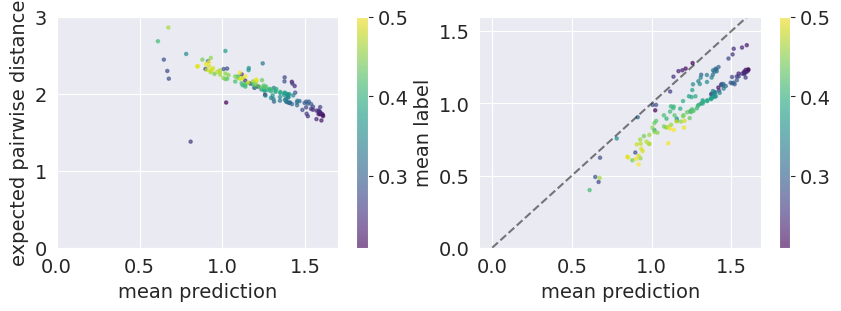

In [95]:
plt.figure(figsize=(10, 3))
first_temp_idx = 10
plt.subplot(121)
plt.scatter(pareto_tx3[first_temp_idx::2, 0], pareto_tx3[first_temp_idx::2, 1], s=5, alpha=0.6,
            c=temperatures[first_temp_idx::2], cmap='viridis')
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('expected pairwise distance');
plt.xlim([0, 1.7]);
plt.ylim([0, 3]);

plt.subplot(122)
plt.scatter(pareto_tx3[first_temp_idx::2, 0], pareto_tx3[first_temp_idx::2, 2], s=5, alpha=0.6,
            c=temperatures[first_temp_idx::2], cmap='viridis')
plt.plot([0, 1.6], [0, 1.6], '--k', alpha=0.5)
plt.ylim([0, 1.6]);
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('mean label');

In [111]:
PATH = '/homefs/home/wongfanc/density-ratio-estimation/aav-models/'
temperatures = np.arange(0.2, 0.501, 0.001)
temp2theta = {
    temp: np.load(PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

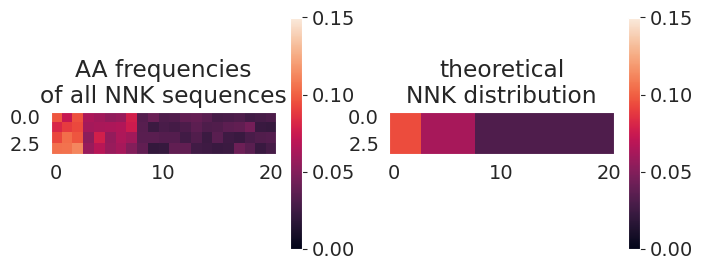

In [14]:
# sanity checking theoretical and empirical NNK distributions
n_val = 1000
_, valohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(aav.PNUC_NNK_LXA, n_val)
fit_lxa = aav.fit_mle_paa(valohe_nxlxa)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(fit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof all NNK sequences')
plt.grid(None)
plt.colorbar();
plt.subplot(122)
plt.imshow(aav.PAA_NNK_LXA, vmin=0, vmax=0.15)
plt.title('theoretical\nNNK distribution')
plt.grid(None)
plt.colorbar();

0.10781686136743122
Calibration ESS: 502
0.10781686136743122
0.03158848323905261
Mean design prediction: 1.1068. Mean IW calibration prediction: 1.1011


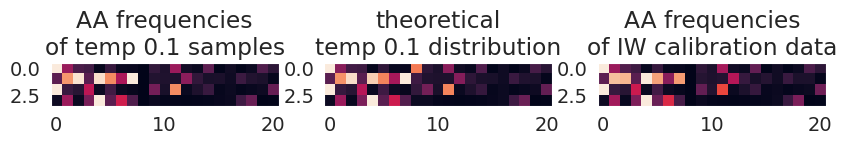

In [137]:
# sanity checking theoretical and empirical design distributions
# using design data and IW calibration data
reload(aav)
n_design = 100000
n_cal = 100000
temp = 0.1

# true frequencies
design_pnuc_lxa = aav.normalize_theta(temp2theta[temp])
design_paa_lxa = aav.get_aa_probs_from_nuc_probs(design_pnuc_lxa)

# fit frequencies to design samples
_, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
    temp2theta[temp], n_design, normalize=True, reject_stop_codon=True)
fit_lxa = aav.fit_mle_paa(designohe_nxlxa)
print(np.max(np.abs(fit_lxa - design_paa_lxa)))

# design predictions
preddesign_n = model.predict(designohe_nxlxa)
imputed_mean = np.mean(preddesign_n)
    
    
# fit frequencies to IWed calibration data 
_, calohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
    aav.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True)
caldr_n = aav.get_density_ratios(calohe_nxlxa, temp2theta[temp])
ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
print('Calibration ESS: {}'.format(int(ess)))
caldr_n = caldr_n / np.sum(caldr_n) * n_cal
iwfit_lxa = aav.fit_mle_paa(calohe_nxlxa, weight_n=caldr_n)
print(np.max(np.abs(iwfit_lxa - design_paa_lxa)))
print(np.max(np.abs(iwfit_lxa - fit_lxa)))

# IW calibration predictions
predcal_n = model.predict(calohe_nxlxa)
iw_cal_mean = np.mean(caldr_n * predcal_n)
print('Mean design prediction: {:.4f}. Mean IW calibration prediction: {:.4f}'.format(
    imputed_mean, iw_cal_mean
))

# plot
plt.figure(figsize=(10, 2))
plt.subplot(131)
plt.imshow(fit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof temp {} samples'.format(temp))
plt.grid(None)
# plt.colorbar();
plt.subplot(132)
plt.imshow(design_paa_lxa, vmin=0, vmax=0.15)
plt.title('theoretical\ntemp {} distribution'.format(temp))
plt.grid(None)
# plt.colorbar();
plt.subplot(133)
plt.imshow(iwfit_lxa, vmin=0, vmax=0.15)
plt.title('AA frequencies\nof IW calibration data')
plt.grid(None)
# plt.colorbar();

In [100]:
reload(aav)
temp2mean = aav.get_true_mean_label_from_theta(temp2theta, seq2yvar) 

True mean for temperature...
    0.2000 is 1.2971. (0 sec)
    0.2010 is 1.2585. (0 sec)
    0.2020 is 1.2297. (1 sec)
    0.2030 is 1.0775. (1 sec)
    0.2040 is 1.2377. (1 sec)
    0.2050 is 1.2467. (1 sec)
    0.2060 is 1.4407. (1 sec)
    0.2070 is 1.2752. (2 sec)
    0.2080 is 1.2432. (2 sec)
    0.2090 is 1.3251. (2 sec)
    0.2100 is 0.9515. (2 sec)
    0.2110 is 1.4319. (2 sec)
    0.2120 is 1.2326. (3 sec)
    0.2130 is 1.3086. (3 sec)
    0.2140 is 1.2790. (3 sec)
    0.2150 is 1.2657. (3 sec)
    0.2160 is 1.2407. (3 sec)
    0.2170 is 1.2560. (4 sec)
    0.2180 is 1.2096. (4 sec)
    0.2190 is 1.2421. (4 sec)
    0.2200 is 1.2318. (4 sec)
    0.2210 is 1.4300. (4 sec)
    0.2220 is 1.2349. (4 sec)
    0.2230 is 1.2688. (5 sec)
    0.2240 is 1.1093. (5 sec)
    0.2250 is 1.2354. (5 sec)
    0.2260 is 1.2220. (5 sec)
    0.2270 is 1.2395. (5 sec)
    0.2280 is 1.4029. (6 sec)
    0.2290 is 1.2291. (6 sec)
    0.2300 is 1.2292. (6 sec)
    0.2310 is 1.2414. (6 sec)
    0.2320 

    0.4660 is 0.7199. (53 sec)
    0.4670 is 0.7009. (53 sec)
    0.4680 is 0.7347. (53 sec)
    0.4690 is 0.7079. (53 sec)
    0.4700 is 0.8366. (53 sec)
    0.4710 is 0.6896. (54 sec)
    0.4720 is 0.7209. (54 sec)
    0.4730 is 0.6981. (54 sec)
    0.4740 is 0.7157. (54 sec)
    0.4750 is 0.6678. (54 sec)
    0.4760 is 0.8751. (55 sec)
    0.4770 is 0.8644. (55 sec)
    0.4780 is 0.8784. (55 sec)
    0.4790 is 0.6645. (55 sec)
    0.4800 is 0.6694. (55 sec)
    0.4810 is 0.7115. (56 sec)
    0.4820 is 0.6368. (56 sec)
    0.4830 is 0.8446. (56 sec)
    0.4840 is 0.6853. (56 sec)
    0.4850 is 0.6278. (56 sec)
    0.4860 is 0.6309. (57 sec)
    0.4870 is 0.6396. (57 sec)
    0.4880 is 0.6250. (57 sec)
    0.4890 is 0.8391. (57 sec)
    0.4900 is 0.6143. (57 sec)
    0.4910 is 0.6035. (58 sec)
    0.4920 is 0.8316. (58 sec)
    0.4930 is 0.8201. (58 sec)
    0.4940 is 0.8247. (58 sec)
    0.4950 is 0.7787. (58 sec)
    0.4960 is 0.7236. (59 sec)
    0.4970 is 0.3477. (59 sec)
    0.49

3.1237195459767526 4.936618907090937


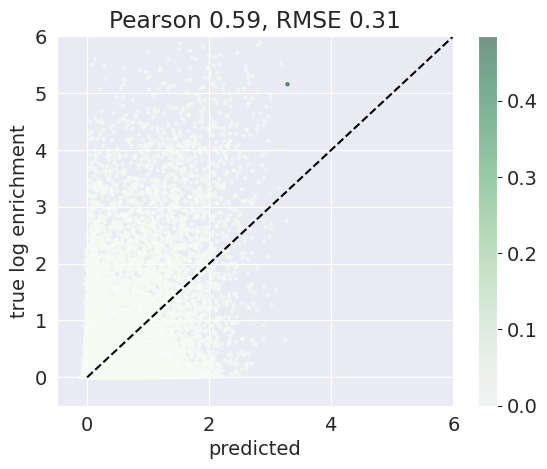

In [16]:
temp = 0.1
pred_n = model.predict(seq_n)
theta_lxa = temp2theta[temp]
paa_lxa = aav.get_aa_probs_from_nuc_probs(aav.normalize_theta(theta_lxa))
ll_n = aav.get_nostop_loglikelihood(ohe_nxlxa, paa_lxa)
p_n = np.exp(ll_n)
print(np.sum(p_n * pred_n), np.sum(p_n * y_n))

plt.scatter(pred_n, y_n, c=p_n, alpha=0.5, s=5, cmap='Greens')
plt.colorbar()
plt.plot([0, 6], [0, 6], '--k')
r, p = sc.stats.pearsonr(y_n, pred_n)
rmse = np.sqrt(np.mean(np.square(y_n - pred_n)))

plt.ylim([-0.5, 6]);
plt.xlim([-0.5, 6])
plt.title('Pearson {:.2f}, RMSE {:.2f}'.format(r, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

In [127]:
# mean
reload(aav)
n_design = 100000
n_cal = 5000

truemean_t = []
pp_t = []
imputed_t = []

for temp in temperatures:
    if temp in [0.25400000000000006, 0.2790000000000001]:
        imputed_t.append(np.nan)
        pp_t.append(np.nan)
        truemean_t.append(temp2mean[temp])
        continue
    
    print(temp)

    theta_lxa = temp2theta[temp]

    # sample from design distribution and get predictions
    _, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
        theta_lxa, n_design, normalize=True, reject_stop_codon=True
    )
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    imputed_t.append(imputed_mean)

    # sample calibration data from NNK
    _, calohe_nxlxa, calseq_n = aav.sample_ohe_from_nuc_distribution(
        aav.PNUC_NNK_LXA, n_cal, reject_stop_codon=True
    )
    ycal_n = np.array([seq2yvar[seq][0] for seq in calseq_n])

    # weight NNK calibration data
    caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa)
    # caldr_n = caldr_n / np.sum(caldr_n) * n_cal
    ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
    
    # IW calibration estimates
    predcal_n = model.predict(calohe_nxlxa) 
    iw_cal_mean = np.mean(caldr_n * predcal_n)
    rect = np.mean(caldr_n * (ycal_n - predcal_n))
    
    pp = imputed_mean + rect
    pp_t.append(pp)
    truemean_t.append(temp2mean[temp])
    
    # print('Mean NNK label: {:.3f}'.format(np.mean(ycal_n)))
    print('Calibration ESS: {}'.format(int(ess)))
    print('Imputed mean: {:.3f}, IW mean calibration prediction: {:.3f}'.format(imputed_mean, iw_cal_mean))
    print('True mean:    {:.3f}, IW mean calibration label: {:.3f}, PP estimate: {:.3f}'.format(
        temp2mean[temp], np.mean(caldr_n * ycal_n), pp))
    print()

0.2
Calibration ESS: 3
Imputed mean: 1.661, IW mean calibration prediction: 2.926
True mean:    1.297, IW mean calibration label: 2.264, PP estimate: 0.999

0.201
Calibration ESS: 2
Imputed mean: 1.625, IW mean calibration prediction: 0.602
True mean:    1.258, IW mean calibration label: 0.542, PP estimate: 1.566

0.202
Calibration ESS: 2
Imputed mean: 1.258, IW mean calibration prediction: 4.852
True mean:    1.230, IW mean calibration label: 5.096, PP estimate: 1.503

0.203
Calibration ESS: 4
Imputed mean: 1.098, IW mean calibration prediction: 0.002
True mean:    1.078, IW mean calibration label: -0.026, PP estimate: 1.070

0.20400000000000001
Calibration ESS: 2
Imputed mean: 1.613, IW mean calibration prediction: 0.647
True mean:    1.238, IW mean calibration label: 0.442, PP estimate: 1.409

0.20500000000000002
Calibration ESS: 4
Imputed mean: 1.613, IW mean calibration prediction: 0.839
True mean:    1.247, IW mean calibration label: 0.485, PP estimate: 1.259

0.20600000000000002

Calibration ESS: 6
Imputed mean: 1.562, IW mean calibration prediction: 0.604
True mean:    1.203, IW mean calibration label: 0.469, PP estimate: 1.427

0.24900000000000005
Calibration ESS: 6
Imputed mean: 1.141, IW mean calibration prediction: 1.727
True mean:    0.967, IW mean calibration label: 1.355, PP estimate: 0.770

0.25000000000000006
Calibration ESS: 3
Imputed mean: 1.160, IW mean calibration prediction: 0.711
True mean:    1.185, IW mean calibration label: 0.784, PP estimate: 1.233

0.25100000000000006
Calibration ESS: 4
Imputed mean: 1.561, IW mean calibration prediction: 1.380
True mean:    1.205, IW mean calibration label: 1.073, PP estimate: 1.254

0.25200000000000006
Calibration ESS: 3
Imputed mean: 1.559, IW mean calibration prediction: 1.777
True mean:    1.206, IW mean calibration label: 1.357, PP estimate: 1.139

0.25300000000000006
Calibration ESS: 11
Imputed mean: 0.750, IW mean calibration prediction: 0.023
True mean:    0.636, IW mean calibration label: -0.048, 

Calibration ESS: 6
Imputed mean: 1.487, IW mean calibration prediction: 1.191
True mean:    1.138, IW mean calibration label: 0.914, PP estimate: 1.211

0.2990000000000001
Calibration ESS: 6
Imputed mean: 1.484, IW mean calibration prediction: 1.494
True mean:    1.129, IW mean calibration label: 1.069, PP estimate: 1.059

0.3000000000000001
Calibration ESS: 5
Imputed mean: 1.346, IW mean calibration prediction: 1.138
True mean:    1.198, IW mean calibration label: 1.082, PP estimate: 1.289

0.3010000000000001
Calibration ESS: 3
Imputed mean: 0.953, IW mean calibration prediction: 1.227
True mean:    0.931, IW mean calibration label: 1.314, PP estimate: 1.039

0.3020000000000001
Calibration ESS: 3
Imputed mean: 1.400, IW mean calibration prediction: 1.272
True mean:    1.251, IW mean calibration label: 1.209, PP estimate: 1.337

0.3030000000000001
Calibration ESS: 4
Imputed mean: 1.469, IW mean calibration prediction: 0.588
True mean:    1.126, IW mean calibration label: 0.513, PP esti

Calibration ESS: 7
Imputed mean: 1.399, IW mean calibration prediction: 0.325
True mean:    1.073, IW mean calibration label: 0.261, PP estimate: 1.335

0.34700000000000014
Calibration ESS: 6
Imputed mean: 1.373, IW mean calibration prediction: 1.511
True mean:    1.048, IW mean calibration label: 1.095, PP estimate: 0.957

0.34800000000000014
Calibration ESS: 6
Imputed mean: 1.282, IW mean calibration prediction: 1.189
True mean:    1.148, IW mean calibration label: 1.184, PP estimate: 1.276

0.34900000000000014
Calibration ESS: 5
Imputed mean: 1.343, IW mean calibration prediction: 1.036
True mean:    1.003, IW mean calibration label: 0.769, PP estimate: 1.076

0.35000000000000014
Calibration ESS: 6
Imputed mean: 1.278, IW mean calibration prediction: 1.908
True mean:    1.132, IW mean calibration label: 1.561, PP estimate: 0.931

0.35100000000000015
Calibration ESS: 6
Imputed mean: 1.262, IW mean calibration prediction: 0.668
True mean:    1.097, IW mean calibration label: 0.541, PP

Calibration ESS: 5
Imputed mean: 1.162, IW mean calibration prediction: 0.872
True mean:    1.016, IW mean calibration label: 0.885, PP estimate: 1.176

0.3950000000000002
Calibration ESS: 7
Imputed mean: 1.286, IW mean calibration prediction: 1.650
True mean:    0.970, IW mean calibration label: 1.313, PP estimate: 0.949

0.3960000000000002
Calibration ESS: 7
Imputed mean: 1.055, IW mean calibration prediction: 1.000
True mean:    0.894, IW mean calibration label: 0.750, PP estimate: 0.805

0.3970000000000002
Calibration ESS: 9
Imputed mean: 0.982, IW mean calibration prediction: 0.618
True mean:    0.700, IW mean calibration label: 0.371, PP estimate: 0.735

0.3980000000000002
Calibration ESS: 10
Imputed mean: 1.308, IW mean calibration prediction: 1.598
True mean:    0.998, IW mean calibration label: 1.237, PP estimate: 0.948

0.3990000000000002
Calibration ESS: 9
Imputed mean: 1.121, IW mean calibration prediction: 1.274
True mean:    0.955, IW mean calibration label: 0.969, PP est

Calibration ESS: 8
Imputed mean: 1.014, IW mean calibration prediction: 0.738
True mean:    0.833, IW mean calibration label: 0.893, PP estimate: 1.169

0.4430000000000002
Calibration ESS: 11
Imputed mean: 1.199, IW mean calibration prediction: 0.420
True mean:    0.892, IW mean calibration label: 0.239, PP estimate: 1.017

0.44400000000000023
Calibration ESS: 7
Imputed mean: 1.209, IW mean calibration prediction: 1.115
True mean:    0.911, IW mean calibration label: 0.791, PP estimate: 0.885

0.44500000000000023
Calibration ESS: 10
Imputed mean: 1.215, IW mean calibration prediction: 1.116
True mean:    0.921, IW mean calibration label: 0.920, PP estimate: 1.019

0.44600000000000023
Calibration ESS: 6
Imputed mean: 0.979, IW mean calibration prediction: 0.622
True mean:    0.797, IW mean calibration label: 0.282, PP estimate: 0.638

0.44700000000000023
Calibration ESS: 8
Imputed mean: 1.215, IW mean calibration prediction: 0.805
True mean:    0.908, IW mean calibration label: 0.546, P

Calibration ESS: 9
Imputed mean: 0.822, IW mean calibration prediction: 0.947
True mean:    0.614, IW mean calibration label: 0.721, PP estimate: 0.596

0.49100000000000027
Calibration ESS: 14
Imputed mean: 0.826, IW mean calibration prediction: 0.719
True mean:    0.604, IW mean calibration label: 0.540, PP estimate: 0.647

0.49200000000000027
Calibration ESS: 7
Imputed mean: 1.118, IW mean calibration prediction: 1.491
True mean:    0.832, IW mean calibration label: 1.202, PP estimate: 0.829

0.49300000000000027
Calibration ESS: 10
Imputed mean: 1.100, IW mean calibration prediction: 0.454
True mean:    0.820, IW mean calibration label: 0.282, PP estimate: 0.928

0.49400000000000027
Calibration ESS: 10
Imputed mean: 1.116, IW mean calibration prediction: 1.044
True mean:    0.825, IW mean calibration label: 0.705, PP estimate: 0.777

0.4950000000000003
Calibration ESS: 14
Imputed mean: 1.067, IW mean calibration prediction: 1.103
True mean:    0.779, IW mean calibration label: 0.883,

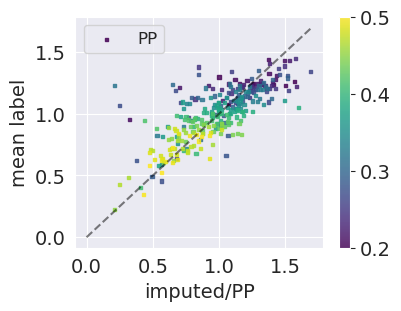

In [128]:
plt.figure(figsize=(4, 3))
# plt.scatter(imputed_t, truemean_t, s=5, alpha=0.8, c=temperatures, cmap='viridis', label='imputed')
plt.scatter(pp_t, truemean_t, s=5, alpha=0.8, marker='s', c=temperatures, cmap='viridis', label='PP')
# for imp, pp, true in zip(imputed_t, pp_t, truemean_t):
#     plt.plot([imp, pp], [true, true], c='k', linewidth=1, alpha=0.5)
plt.legend(fontsize=12);
plt.colorbar()
plt.xlabel('imputed/PP');
plt.ylabel('mean label');
plt.plot([0, 1.7], [0, 1.7], '--k', alpha=0.5);

In [114]:
reload(aav)
threshold = 1
seq2ythresh = {seq: (y >= threshold).astype(float) for seq, y in seq2y.items()}
temp2meanthresh = aav.get_true_mean_label_from_theta(temp2theta, seq2ythresh) 

True mean label for temperature...
    0.1000 is 0.9895. (0 sec)
    0.1100 is 0.6125. (0 sec)
    0.1200 is 0.8604. (0 sec)
    0.1300 is 0.8543. (1 sec)
    0.1400 is 0.8224. (1 sec)
    0.1500 is 0.9879. (1 sec)
    0.1600 is 0.9875. (1 sec)
    0.1700 is 0.9835. (1 sec)
    0.1800 is 0.6147. (2 sec)
    0.1900 is 0.7915. (2 sec)
    0.2000 is 0.9692. (2 sec)
    0.2100 is 0.9792. (2 sec)
    0.2200 is 0.9776. (2 sec)
    0.2300 is 0.6644. (2 sec)
    0.2400 is 0.7629. (3 sec)
    0.2500 is 0.9201. (3 sec)
    0.2600 is 0.7519. (3 sec)
    0.2700 is 0.7329. (3 sec)
    0.2800 is 0.6508. (3 sec)
    0.2900 is 0.7584. (4 sec)
    0.3000 is 0.9475. (4 sec)
    0.3100 is 0.9429. (4 sec)
    0.3200 is 0.9384. (4 sec)
    0.3300 is 0.9292. (4 sec)
    0.3400 is 0.7388. (4 sec)
    0.3500 is 0.9191. (5 sec)
    0.3600 is 0.8906. (5 sec)
    0.3700 is 0.7674. (5 sec)
    0.3800 is 0.8799. (5 sec)
    0.3900 is 0.7369. (5 sec)
    0.4000 is 0.8632. (6 sec)
    0.4100 is 0.7554. (6 sec)
    0

In [124]:
# probability of exceedance
reload(aav)
n_design = 100000
n_cal = 1000
threshold = 1

truemean_t = []
imputed_t = []
pp_t = []

for temp in temperatures:
    
    print(temp)

    theta_lxa = temp2theta[temp]

    # sample from design distribution and get predictions
    _, designohe_nxlxa, _ = aav.sample_ohe_from_nuc_distribution(
        theta_lxa, n_design, normalize=True, reject_stop_codon=True
    )
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n >= threshold)
    imputed_t.append(imputed_mean)

    # sample calibration data from NNK
    _, calohe_nxlxa, calseq_n = aav.sample_ohe_from_nuc_distribution(
        aav.PNUC_NNK_LXA, n_cal, reject_stop_codon=True
    )
    ycal_n = np.array([seq2y[seq] >= threshold for seq in calseq_n]).astype(float)

    # weight NNK calibration data
    caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa)
    caldr_n = caldr_n / np.sum(caldr_n) * n_cal
    ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
    
    # IW calibration estimates
    predcal_n = model.predict(calohe_nxlxa) 
    predcal_n = np.array(predcal_n >= threshold).astype(float)
    iw_cal_mean = np.mean(caldr_n * predcal_n)
    rect = np.mean(caldr_n * (ycal_n - predcal_n))
    
    pp = imputed_mean + rect
    pp_t.append(pp)
    truemean_t.append(temp2meanthresh[temp])
    
    # print('Mean NNK label: {:.3f}'.format(np.mean(ycal_n)))
    print('Calibration ESS: {}'.format(int(ess)))
    print('Imputed mean: {:.3f}, IW mean calibration prediction: {:.3f}'.format(imputed_mean, iw_cal_mean))
    print('True mean:    {:.3f}, IW mean calibration label: {:.3f}, PP estimate: {:.3f}'.format(
        temp2meanthresh[temp], np.mean(caldr_n * ycal_n), pp))
    print()

0.1
Calibration ESS: 1
Imputed mean: 0.999, IW mean calibration prediction: 0.974
True mean:    0.990, IW mean calibration label: 0.023, PP estimate: 0.047

0.11
Calibration ESS: 2
Imputed mean: 0.997, IW mean calibration prediction: 0.995
True mean:    0.612, IW mean calibration label: 0.026, PP estimate: 0.029

0.12
Calibration ESS: 2
Imputed mean: 0.997, IW mean calibration prediction: 0.908
True mean:    0.860, IW mean calibration label: 0.731, PP estimate: 0.819

0.13
Calibration ESS: 1
Imputed mean: 0.996, IW mean calibration prediction: 0.995
True mean:    0.854, IW mean calibration label: 0.963, PP estimate: 0.964

0.13999999999999999
Calibration ESS: 1
Imputed mean: 0.996, IW mean calibration prediction: 0.823
True mean:    0.822, IW mean calibration label: 0.117, PP estimate: 0.290

0.14999999999999997
Calibration ESS: 7
Imputed mean: 0.997, IW mean calibration prediction: 0.080
True mean:    0.988, IW mean calibration label: 0.061, PP estimate: 0.978

0.15999999999999998
Cal

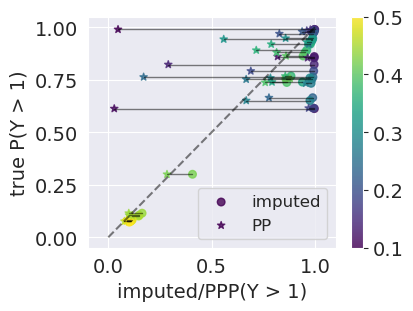

In [125]:
plt.figure(figsize=(4, 3))
plt.scatter(imputed_t, truemean_t, s=30, alpha=0.8, c=temperatures, cmap='viridis', label='imputed')
plt.scatter(pp_t, truemean_t, s=30, alpha=0.8, marker='*', c=temperatures, cmap='viridis', label='PP')
for imp, pp, true in zip(imputed_t, pp_t, truemean_t):
    plt.plot([imp, pp], [true, true], c='k', linewidth=1, alpha=0.5)
plt.legend(fontsize=12);
plt.colorbar()
plt.xlabel('imputed/PPP(Y > {})'.format(threshold));
plt.ylabel('true P(Y > {})'.format(threshold));
plt.plot([0, 1], [0, 1], '--k', alpha=0.5);
plt.xlim([-0.1, 1.1]);